In [ ]:
%pip install numpy deepxde matplotlib torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.4/184.4 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 8.4 MB/s eta 0:00:00


In [ ]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt

No backend selected.
Finding available backend...


Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.
Instructions for updating:
non-resource variables are not supported in the long term
Enable just-in-time compilation with XLA.



Found tensorflow.compat.v1
Setting the default backend to "tensorflow.compat.v1". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)


In [ ]:
dde.backend.set_default_backend('pytorch')

Setting the default backend to "pytorch". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)


In [ ]:
# PARÂMETROS DIMENSIONAIS
l = 20
tf = 80

#PARAMETROS DO MODELO
d = 0.0139
p = 0.0553
dl = d / (p * l**2)

#DECLARAÇÃO DOMÍNIO ESPACIAL E TEMPORAL
geom = dde.geometry.Rectangle([0, 0], [1, 1])
time = dde.geometry.TimeDomain(0, tf * p)
geomtime = dde.geometry.GeometryXTime(geom, time)

#EQUAÇÃO RESIDUAL
def pde(x, c):

    c_t = dde.grad.jacobian(c, x, i=0, j=2)
    c_xx = dde.grad.hessian(c, x, i=0, j=0)
    c_yy = dde.grad.hessian(c, x, i=0, j=1)
    return c_t - (dl * (c_xx + c_yy) + c)

#CONDIÇÃO INICIAL
def ic_func(x): return np.exp(-100 * ((x[:, 0:1] - 0.5)**2 + (x[:, 1:2] - 0.5)**2))
ic = dde.icbc.IC(geomtime, ic_func, lambda _, on_initial: on_initial)

#CONDIÇÃO DE CONTORNO
def bc_func(x): return 0
bc = dde.icbc.NeumannBC(geomtime, bc_func, lambda _, on_boundary: on_boundary)

def treinamento(n_domain, n_neurons, iteration = 50_000):

    #DECLARAÇÃO TREINAMENTO
    data = dde.data.TimePDE(
        geomtime,
        pde,
        [ic, bc],
        num_domain = n_domain,
        num_boundary = 1_000,
        num_initial = 1_000,
        num_test = 1_000
    )

    net = dde.nn.FNN(
        [3] + [n_neurons] * 3 + [1],
        'tanh',
        'Glorot uniform'
    )

    model = dde.Model(data, net)
    model.compile('adam', lr=1e-3)

    losshistory, train_state = model.train(
        iteration,
    )

    return model

In [ ]:
# TREINAMENTO DOS MODELOS
n_neurons = [50, 100, 150]
n_domain = [1000, 2000, 3000, 4000, 5000]

for i in n_neurons:
    for j in n_domain:
        treinamento(j, i)

Compiling model...
Building feed-forward neural network...
'build' took 0.099807 s

'compile' took 0.806888 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [3.35e-01, 1.42e-01, 9.25e-02]    [4.84e-01, 1.42e-01, 9.25e-02]    []  
1000      [2.15e-04, 1.46e-02, 1.30e-04]    [3.59e-04, 1.46e-02, 1.30e-04]    []  
2000      [2.29e-04, 1.44e-02, 1.70e-04]    [3.80e-04, 1.44e-02, 1.70e-04]    []  
3000      [3.47e-04, 1.37e-02, 1.62e-04]    [5.71e-04, 1.37e-02, 1.62e-04]    []  
4000      [5.75e-04, 1.25e-02, 2.00e-04]    [1.27e-03, 1.25e-02, 2.00e-04]    []  
5000      [8.44e-04, 9.84e-03, 3.71e-04]    [2.05e-03, 9.84e-03, 3.71e-04]    []  
6000      [1.98e-03, 2.10e-03, 2.12e-04]    [4.34e-03, 2.10e-03, 2.12e-04]    []  
7000      [2.07e-03, 6.29e-04, 6.39e-05]    [3.01e-03, 6.29e-04, 6.39e-05]    []  
8000      [1.97e-03, 4.25e-04, 4.00e-05]    [2.56e-03, 4.25e-04, 4.00e-05]    []  
9000      [1.91e-03, 3.66e-04, 5.

In [ ]:
import torch

TAM = 100
X, Y = torch.linspace(0, 1, TAM), torch.linspace(0, 1, TAM)
T = torch.linspace(0, TF * P, 80)

INPUT = torch.cartesian_prod(X, Y, T)
OUT = MODEL.predict(INPUT)
OUT = OUT.reshape(TAM, TAM, 80).T
OUT.shape

(80, 100, 100)

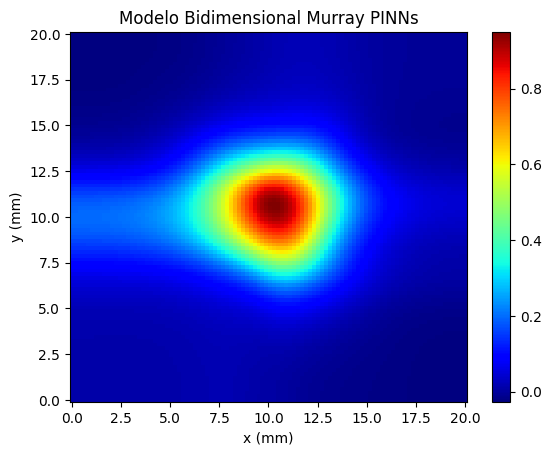

In [ ]:
figure, ax = plt.subplots()

plot = ax.pcolormesh(X * L, Y * L, OUT[-1], cmap='jet')
ax.set_title('Modelo Bidimensional Murray PINNs')
ax.set_xlabel('x (mm)')
ax.set_ylabel('y (mm)')

plt.colorbar(plot)
plt.show()